In [2]:
import torch
import clip
import os
import sys
import torch
import torchvision.transforms as T
import time
import shutil
from os.path import join
base_directory = "../"
sys.path.insert(0, base_directory)

output_base_dir = join(base_directory, "./output/sd2-notebook/")
output_directory = join(output_base_dir, "clip_image_encoder/")

try: 
    shutil.rmtree(output_directory)
except Exception as e:
    print(e, "\n", "Creating the path...")
    os.makedirs(output_directory, exist_ok=True)
else:
    os.makedirs(output_directory, exist_ok=True)


from stable_diffusion.stable_diffusion import StableDiffusion
from stable_diffusion.model.clip_image_encoder import CLIPImageEncoder
from utility.labml.monit import section
# from stable_diffusion.utils.utils import SectionManager as section
from stable_diffusion.utils.model import *
from stable_diffusion.utils.utils import *
from stable_diffusion.model_paths import IODirectoryTree
from torchvision.transforms import ToPILImage

from pathlib import Path

In [3]:
batch_size = 1
device = get_device(None)
pt = IODirectoryTree(base_directory=base_directory)

INFO: `device` is None. Falling back to current device.
INFO: Using CUDA device 0: NVIDIA GeForce RTX 3080 Ti.


In [5]:
# let's load an image from disk
img = load_img(join(base_directory, ".test/test-images/test_img.jpg")).to(device)
get_memory_status()

Total: 12287 MiB
Free: 11066 MiB
Used: 1221 MiB


In [6]:
img.mean(), img.std()

(tensor(-0.0400, device='cuda:0'), tensor(0.3494, device='cuda:0'))

torch.Size([1, 3, 512, 512])


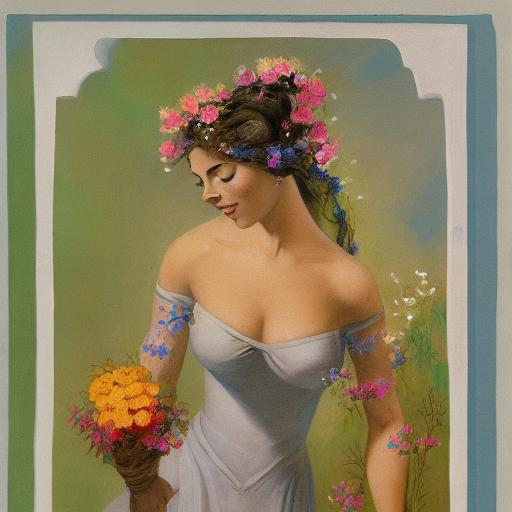

In [7]:
# print its shape and show it
print(img.shape)
to_pil(img.squeeze())

In [8]:
# instantiate the image encoder
img_encoder = CLIPImageEncoder(device=device)
get_memory_status()

INFO: Using CUDA device 0: NVIDIA GeForce RTX 3080 Ti.
Total: 12287 MiB
Free: 10610 MiB
Used: 1677 MiB


In [11]:
# load the clip model
img_encoder.load_clip_model(**pt.clip_model)
get_memory_status()
img_encoder.initialize_preprocessor()

Total: 12287 MiB
Free: 8816 MiB
Used: 3471 MiB
Initializing image preprocessor...


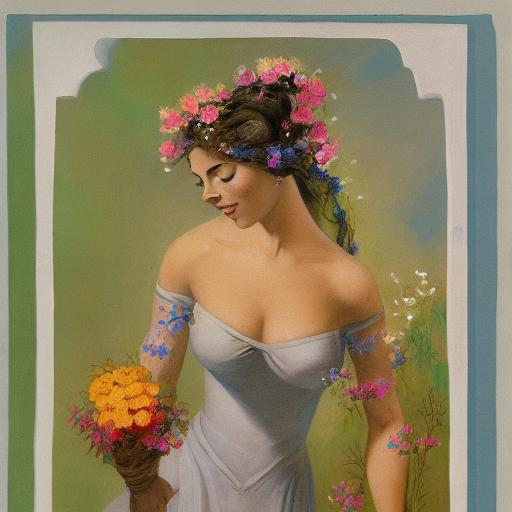

In [12]:
pil_img = to_pil(img.squeeze())
pil_img

In [13]:
img_2 = img_encoder.convert_image_to_tensor(pil_img)

In [14]:
torch.norm(img - img_2)

tensor(1.6265, device='cuda:0')

In [15]:
prep_from_tensor = img_encoder.preprocess_input(img)

c:\Users\igor-\anaconda3\envs\kcg\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [16]:
prep_from_tensor

tensor([[[[-0.3846, -0.4325, -0.4367,  ..., -0.2760, -0.2462, -0.1473],
          [-0.3880, -0.3512, -0.4838,  ..., -0.3178, -0.2594, -0.2185],
          [-0.3950, -0.4012, -0.4166,  ..., -0.2782, -0.2073, -0.2095],
          ...,
          [-0.5471, -0.7379, -0.7120,  ..., -0.2594, -0.1989, -0.1718],
          [-0.5299, -0.7348, -0.6640,  ..., -0.2594, -0.1989, -0.1718],
          [-0.4337, -0.6619, -0.5681,  ..., -0.2594, -0.1989, -0.1718]],

         [[-0.5450, -0.5944, -0.5450,  ..., -0.4034, -0.3728, -0.2711],
          [-0.5786, -0.5408, -0.5870,  ..., -0.4464, -0.3864, -0.3443],
          [-0.5065, -0.5129, -0.5280,  ..., -0.4057, -0.3328, -0.3351],
          ...,
          [-0.4720, -0.6403, -0.5257,  ..., -0.3564, -0.3242, -0.2963],
          [-0.4544, -0.6371, -0.4764,  ..., -0.3564, -0.3242, -0.2963],
          [-0.3555, -0.5622, -0.3778,  ..., -0.3564, -0.3242, -0.2963]],

         [[-0.6494, -0.6961, -0.6656,  ..., -0.6573, -0.6283, -0.5320],
          [-0.6243, -0.5884, -

In [17]:
prep_from_img = img_encoder.preprocess_input(pil_img)

In [18]:
torch.norm(prep_from_img - prep_from_tensor)

tensor(2.4906, device='cuda:0')

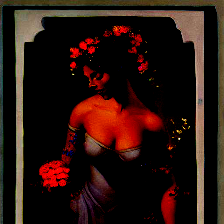

In [19]:
to_pil(prep_from_img.squeeze())

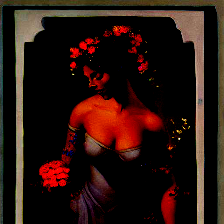

In [20]:
to_pil(prep_from_tensor.squeeze())

## Other tests

In [21]:
def to_rgb(image: PIL.Image.Image):
    return image.convert('RGB')
    
image_processor = T.Compose([T.Resize(224, interpolation=PIL.Image.BICUBIC),
                                T.CenterCrop(224),
                                to_rgb,
                                # img2tensor,
                                # T.Lambda(lambda x: x * (2/255) - 1),                                
                                T.ToTensor(),
                                T.Normalize(
                                    (0.48145466, 0.4578275, 0.40821073), 
                                    (0.26862954, 0.26130258, 0.27577711)
                                    ),
                                T.Lambda(lambda x: x.unsqueeze(0)),
                                ])

In [22]:
from_img = image_processor(pil_img)

In [23]:
from_img.mean(), from_img.std()

(tensor(0.1164), tensor(0.6051))

In [24]:
image_processor = T.Compose([T.Resize(224, interpolation=PIL.Image.BICUBIC),
                                T.CenterCrop(224),
                                T.Lambda(lambda x: 255.0*(x + 1)/2),                                
                                # T.ToTensor(),
                                T.Normalize(
                                    (0.48145466, 0.4578275, 0.40821073), 
                                    (0.26862954, 0.26130258, 0.27577711)
                                    ),
                                # T.Lambda(lambda x: x.unsqueeze(0)),
                                ])

In [25]:
img.mean(), img.std(), img.min()

(tensor(-0.0400, device='cuda:0'),
 tensor(0.3494, device='cuda:0'),
 tensor(-1., device='cuda:0'))

In [26]:
np.array(pil_img).mean()

122.3442014058431

In [27]:
(255*(img + 1)/2).mean()
# same mean??

tensor(122.3989, device='cuda:0')

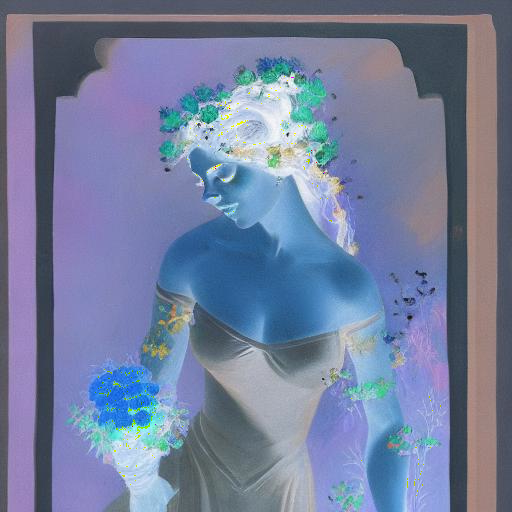

In [28]:
pil_img2 = ToPILImage()((255*(img + 1)/2).squeeze())
pil_img2
# ??

In [29]:
from_tensor = image_processor(img)

In [30]:
torch.norm(from_tensor - from_img.to(device))
# wjat?? why???

tensor(188053.6406, device='cuda:0')

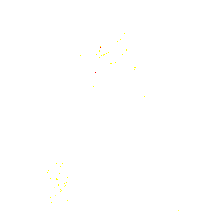

In [31]:
to_pil(from_tensor.squeeze())
## ????

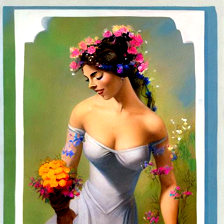

In [32]:
to_pil(from_img.squeeze())